### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/My Drive/CI2020-hackathon/James/'

In [ ]:
device='gpu' # 'tpu'/'gpu'

In [ ]:
if device=='gpu':
  gpu_info = !nvidia-smi
  print('\n'.join(gpu_info))
  device='cuda'

Sat Oct  3 18:48:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data

In [ ]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import pandas as pd
import torch
import time
import pandas as pd
import os

In [ ]:
CloudTop = np.load("../public_data/X_train_CI20.npy")
TrueColor = np.load("../public_data/Y_train_CI20.npy")
TrueColor.shape, CloudTop.shape

((8423, 127, 127, 3), (8423, 127, 127, 3))

Show an example

Text(0.5, 1.0, 'Visible RGB')

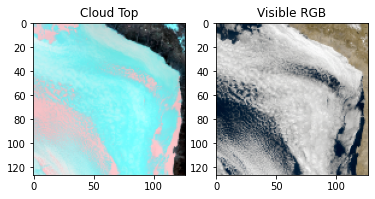

In [ ]:
randindex=5846 # np.random.randint(0,TrueColor.shape[0]) #nice image at randindex = 5846

plt.figure()
plt.subplot(1,2,1)
plt.imshow(array_to_img(CloudTop[randindex,:,:,:]))
plt.title('Cloud Top')

plt.subplot(1,2,2)
plt.imshow(array_to_img(TrueColor[randindex,:,:,:]))
plt.title('Visible RGB')

## Exploratory Data Analysis

### Preprocessing

Here we set a threshold for how many of the pixels in the training set are allowed to be dark and look at look at some examples of those kept and filtered out.

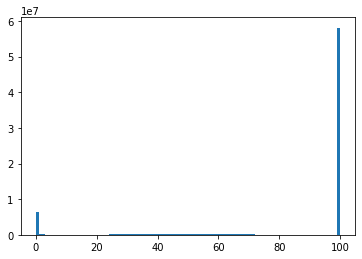

In [ ]:
mask = np.where(np.sum(TrueColor,axis=(1,2,3))>0.)
TrueColorNZ = TrueColor[mask]
CloudTopNZ = CloudTop[mask]

# examine average intensities
saturation = TrueColorNZ.sum(axis=3).flatten().clip(None,100)
plt.hist(saturation, bins=100);
plt.show()

2953 images out of 4517 have no dark pixels.


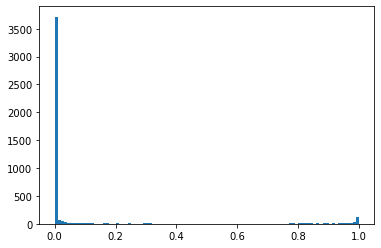

In [ ]:
darkness_intensity = 5

# fraction of pixels which are dark per image
val = (TrueColorNZ.sum(axis=3)<darkness_intensity).mean(axis=(1,2))

plt.hist(val, bins=100);
print(f"{(val==0).sum()} images out of {len(val)} have no dark pixels.")

Removed 977 entries out of 4517
Below are the most dark images kept with cutoff fraction 0.002. Dark regions shown with contour.


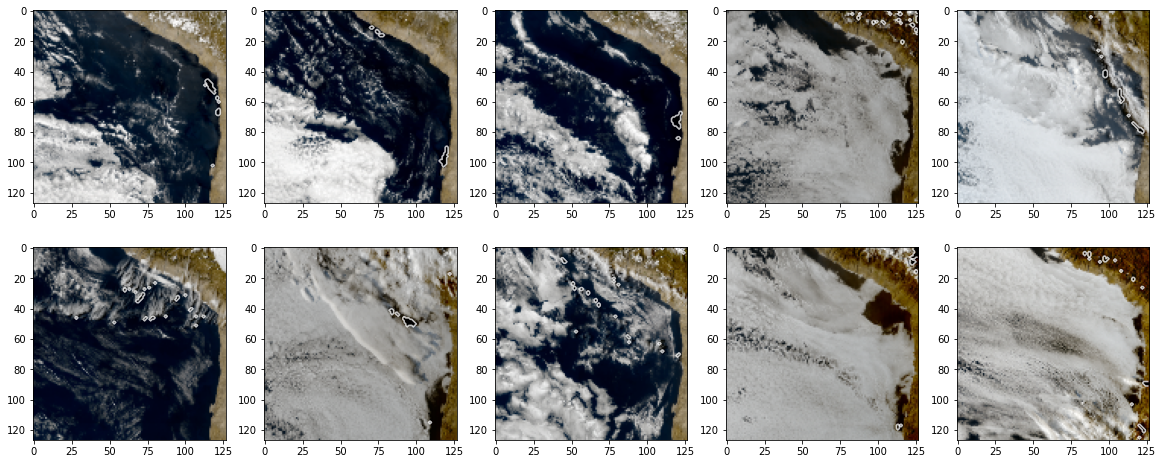

Below are the least dark images discarded with cutoff fraction 0.002. Dark regions shown with contour.


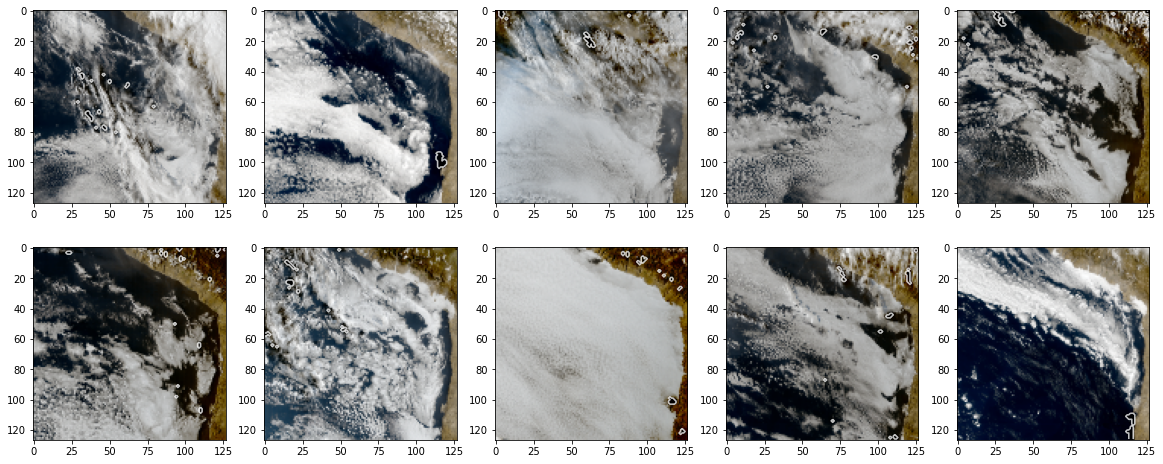

In [ ]:
# keep images with at most this fraction dark
cutoff = 0.002
keep = val<cutoff
print(f"Removed {sum(~keep)} entries out of {len(TrueColorNZ)}")

# Find darkest images kept
indexes = np.arange(len(TrueColorNZ))
keep_indexes = np.array([y[1] for y in sorted(enumerate(indexes[keep]), key=lambda x: val[keep][x[0]], reverse=True)])
discard_indexes = np.array([y[1] for y in sorted(enumerate(indexes[~keep]), key=lambda x: val[~keep][x[0]], reverse=False)])

N=10
max_per_row = 5

print(f'Below are the most dark images kept with cutoff fraction {cutoff}. Dark regions shown with contour.')

plt.figure(figsize=(20,8))
for i, index in enumerate(keep_indexes[:N]):
  plt.subplot((N-1)//max_per_row+1, max_per_row, i+1)
  plt.imshow(array_to_img(TrueColorNZ[index,:,:,:]))
  plt.contour(array_to_img(TrueColorNZ[index,:,:,:].sum(axis=2, keepdims=True)<darkness_intensity), levels=[0,1], colors='white', alpha=0.5)
plt.show()

print(f'Below are the least dark images discarded with cutoff fraction {cutoff}. Dark regions shown with contour.')
plt.figure(figsize=(20,8))
for i, index in enumerate(discard_indexes[:N]):
  plt.subplot((N-1)//max_per_row+1, max_per_row, i+1)
  plt.imshow(array_to_img(TrueColorNZ[index,:,:,:]))
  plt.contour(array_to_img(TrueColorNZ[index,:,:,:].sum(axis=2, keepdims=True)<darkness_intensity), levels=[0,1], colors='white', alpha=0.5)
plt.show()


In the figure above we look at darkest images kept and least dark images discarded. The white contours encircle the dark pixels.

In [ ]:
TrueColorFiltered = TrueColorNZ[keep]
CloudTopFiltered  = CloudTopNZ[keep]

# Set dark pixels to NaN so we don't learn these
TrueColorFiltered[TrueColorFiltered.sum(axis=3)<darkness_intensity] = np.nan

In [ ]:
np.isnan(TrueColorFiltered).mean()

7.657190455623849e-05

In [ ]:
TrueColorFiltered.shape, CloudTopFiltered.shape

((3540, 127, 127, 3), (3540, 127, 127, 3))

In [ ]:
del CloudTop, TrueColor


## U-Net++

In [ ]:
from lib.unet_plus import NestedUNet
from lib.ssim import SSIM

calc_ssim = SSIM(filter_nan=True, channel=3)
loss_fn = lambda x1, x2: -calc_ssim(x1,x2)

In [ ]:
model = NestedUNet(num_classes=3, input_channels=3, deep_supervision=False, nb_filter=[8, 16, 32, 64, 128],).to(device)
optim = torch.optim.Adam(model.parameters())

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

def pad(data):
  return F.pad(input=data, pad=(0, 1, 0, 1), mode='constant', value=0)

In [ ]:
batch_size = 10
test_size=500

tensor_x = pad(torch.from_numpy(CloudTopFiltered.transpose((0,3,1,2))/255))
tensor_y = torch.from_numpy(TrueColorFiltered.transpose((0,3,1,2))/255.)

dataset = TensorDataset(tensor_x,tensor_y)

# split into train and test sets and create dataloader
train_set, test_set = torch.utils.data.random_split(dataset, (len(dataset)-test_size, test_size), generator=torch.Generator().manual_seed(42))
dataloader = DataLoader(train_set, batch_size=batch_size)

test_X, test_y = test_set[:]
test_X = test_X.to(device)
test_y = test_y.to(device)

del tensor_x, tensor_y, train_set, test_set, dataset, CloudTopNZ, TrueColorNZ

In [ ]:
STATS_PERIOD = 50
MODEL_DUMP_ROOT="output_dump"

N=50

class net_container:
    def __init__(self, net, optimizer, loss_func, test_X, test_y, run_name=None):
        self.net = net
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.run_name = run_name
        self.test_X = test_X
        self.test_y = test_y
        
        self.running_train_loss = 0
        self.train_losses = []
        self.test_losses = []
        self.batch = []
        self.time_elapsed = []
        
    
    def train_step(self, X, y, batch_number):
        


        # forward + backward + optimize
        self.net.train()
        
        outputs = self.net(X)[:,:,:-1, :-1]
        train_loss = self.loss_func(outputs, y)

        self.running_train_loss += train_loss.item()
        
        train_loss.backward()
        self.optimizer.step()

        # zero the parameter gradients
        self.optimizer.zero_grad()

        del outputs, train_loss

        # print statistics
        if batch_number == 0 or batch_number % STATS_PERIOD == STATS_PERIOD - 1:    # print every STATS_PERIOD mini-batches

            # Train loss
            if batch_number == 0:
                mean_train_loss = self.running_train_loss
                self.t0 = time.time()
            else:
                mean_train_loss = self.running_train_loss / STATS_PERIOD

            self.train_losses.append(mean_train_loss)
            
            self.running_train_loss = 0.

            # Test loss
            self.net.eval()
            
            test_loss=0
            for i in range((self.test_X.shape[0]-1)//N + 1):
              test_outputs = self.net(self.test_X[i*N:(i+1)*N])[:,:,:-1, :-1]
              l = self.loss_func(test_outputs, self.test_y[i*N:(i+1)*N]).item()
              l = l * min(N, self.test_X.shape[0]-i*N)/self.test_X.shape[0]
              test_loss += l

            self.test_losses.append(test_loss)
           
            self.batch.append(batch_number)
            self.time_elapsed.append(time.time() - self.t0)

            print(f"batch {batch_number} | {self.time_elapsed[-1]}s elapsed | train_loss {mean_train_loss:.5f} | test_loss {self.test_losses[-1]:.5f}"+" "*10, flush=True)
            
            if self.run_name:
                thisdir = os.path.join(MODEL_DUMP_ROOT, self.run_name)
                if batch_number==0:
                    
                    os.system(f"rm -rf {thisdir}")
                    os.makedirs(thisdir)
                    
                              
                df = pd.DataFrame({
                    'time_elapsed':self.time_elapsed,
                    'batch':self.batch,
                    'train_loss':self.train_losses,
                    'test_loss':self.test_losses,
                }).to_csv(os.path.join(thisdir, 'training_stats.csv'))
                
                if test_loss == min(self.test_losses):
                    torch.save(self.net, os.path.join(thisdir, 'best_model.pkl'))

In [ ]:
wrapped_model = net_container(model, optim, loss_fn, test_X, test_y, run_name='unet_filt3')

# initiate batch number
bn = 0

In [ ]:
batch_epochs=[(10, 60), (32, 30), (64, 30), (128, 20), (256, 20)]

for batch_size, epochs in batch_epochs:

  print(f"transition to (batch:{batch_size}, epochs: {epochs})")
  dataloader = DataLoader(dataloader.dataset, batch_size=batch_size)

  for _ in range(epochs):
      
      for X, y in dataloader:
          X = X.to(device)
          y = y.to(device)
          wrapped_model.train_step(X,y,bn)
          bn+=1

## Evaluate and reload best model

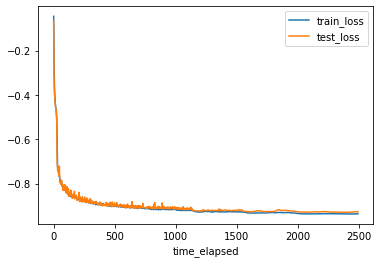

In [ ]:
df = pd.read_csv('output_dump/unet_filt3/training_stats.csv')
df = df[df.train_loss>-1]
df.plot(x='time_elapsed', y=['train_loss', 'test_loss'])

In [ ]:
df.test_loss.min()

-0.9288277089595794

#### Model run differences

Our name for the network vs threshold for fraction of dark pixels allowed

|  filename | cutoff  | 
|-----------|---------|
| filt      | 0.02    |
| filt2     | 0.005   |
| filt3     | 0.002   |

In [ ]:
model = torch.load('output_dump/unet_filt3/best_model.pkl')
model.eval();

In [ ]:
# Calculate scores for test set images
scores = []
for i in range(len(test_X)):
             scores += [loss_fn(model(test_X[i:i+1])[:,:, :-1, :-1], test_y[i:i+1]).item()]

/gdrive/My Drive/CI2020-hackathon/James/lib/ssim.py:30: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output channels_last tensor even if some of the inputs are not in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:924.)
  sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
/gdrive/My Drive/CI2020-hackathon/James/lib/ssim.py:37: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)
  ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))


In [ ]:
# Sort indexes of test set images by score
indexes = [x[0] for x in sorted([(i,s) for i,s in enumerate(scores)], key=lambda x: x[1], reverse=True)]

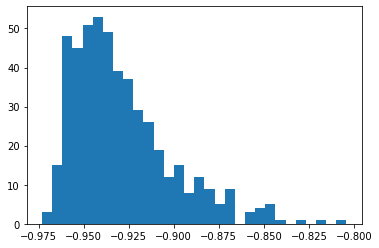

In [ ]:
# Distribution of test set scores
plt.hist(scores, bins=30)
plt.show()

In [ ]:
np.median(scores)

-0.934969425201416

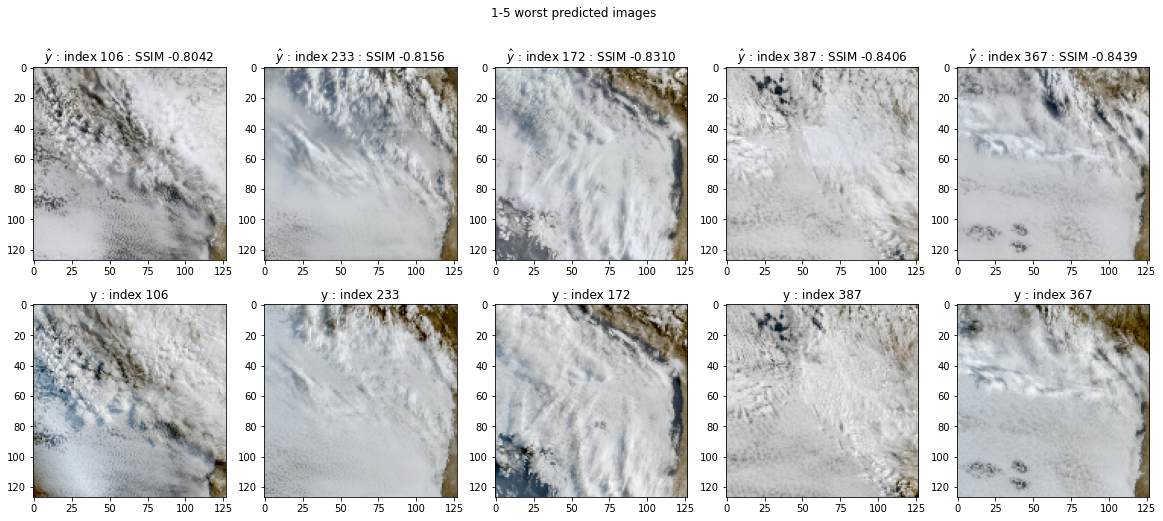

In [ ]:
# Plot preidctions and ground truth of worst scoring test set images

def post_process(imgs):
  return imgs.detach().cpu().numpy().transpose((0,2,3,1))*255

# start at this index
ind=0
# plot this many images
n=5

# Make predictions for worst scoring test set images
img_x = test_X[indexes[ind:ind+n]]
img_y_hat = post_process(model(img_x)[:,:, :-1, :-1])
img_y = post_process(test_y[indexes[ind:ind+n]])
img_y[np.isnan(img_y)]=0

plt.figure(figsize=(20,8))
plt.suptitle(f'{ind+1}-{ind+n} worst predicted images')

for i, index in enumerate(indexes[ind:ind+n]):
  plt.subplot(2,n,i+1)
  plt.imshow(array_to_img(img_y_hat[i]))
  plt.title('$\hat{y}$'+f' : index {index} : SSIM {scores[index]:.4f}')

  plt.subplot(2,n,i+1+n)
  plt.imshow(array_to_img(img_y[i]))
  plt.title(f'y : index {index}')

plt.show()

In [ ]:
X_test = np.load("../public_data/NightVision.npy")

X_test = pad(torch.from_numpy(X_test.transpose((0,3,1,2))/255)).to(device)

predictions = model(X_test).detach().cpu().numpy()[:,:,:-1,:-1].transpose((0,2,3,1))*255

Create and save animation of night RGB predictions

In [ ]:
from matplotlib import rc
import matplotlib.animation as animation

rc('animation', html='jshtml');

fig = plt.figure()
ims = []
for i in range(len(predictions)):
    im = plt.imshow(array_to_img(predictions[i,:,:,:]), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True) 

#please ignore the empty image plotted after the execution and run the next cell

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save('output_dump/unet_filt3/NightVision.mp4', writer=writer)

look at the analogs of one random test image

## Submitting to the online challenge



This script will generate a file called Y_test_CI20_phase1.predict, go to the folder you created in your Google Drive, download the Y_test_CI20.predict file, zip it then submit it in the codalab platform

In [ ]:
X_test = np.load("../public_data/NightVision.npy")

X_test = pad(torch.from_numpy(X_test.transpose((0,3,1,2))/255)).to(device)

predictions = model(X_test).detach().cpu().numpy()[:,:,:-1,:-1].transpose((0,2,3,1))*255

In [ ]:
predictions_file = "predictions"

def save_compress(predictions, name):
    np.save(f'{predictions_file}/{name}.npy', predictions)
    os.system(f"mv {predictions_file}/{name}.npy {predictions_file}/{name}.predict")
    os.system(f"zip -jrm {predictions_file}/{name}.zip {predictions_file}/{name}.predict")
    os.system(f"rm {predictions_file}/{name}.predict")

save_compress(predictions, 'Y_NightVision_stargazer')

In [ ]:
batch_size = 10

X_test = np.load("../public_data/X_test_CI20_phase2.npy")
X_test = pad(torch.from_numpy(X_test.transpose((0,3,1,2))/255)).to(device)

predictions = [model(X_test[i:i+batch_size]).detach().cpu().numpy()[:,:,:-1,:-1].transpose((0,2,3,1))*255 for i in range(0, len(X_test), batch_size)]
predictions = np.concatenate(predictions)

save_compress(predictions, 'Y_test_CI20_phase2_UNet_filt3')